# 2. Visualizing with SOM (3 points)


Visualize the MNIST-784 handwritten digits dataset with SOM and discuss what you can learn from the visualization.

In [1]:
!pip install torchsom

In [ ]:
# download the MNIST_784.arff dataset
import urllib.request

url = "https://www.openml.org/data/download/52667/mnist_784.arff"
filename = "mnist_784.arff"

print("Downloading MNIST_784.arff ...")
urllib.request.urlretrieve(url, filename)
print("Download complete:", filename)

Download complete: mnist_784.arff


In [3]:
from scipy.io import arff
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# load the ARFF file
data, meta = arff.loadarff('mnist_784.arff')
df = pd.DataFrame(data)

# convert byte strings to regular strings
for col in df.select_dtypes([object]):
    df[col] = df[col].apply(lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else int(x))

print(df.head())

   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
3      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
4      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel782  pixel783  pixel784  class  
0       0.0       0.0

In [ ]:
# normalize the data to [0, 1]
from sklearn.preprocessing import MinMaxScaler
X = df.drop('class', axis=1)
y = df['class']

X = X / 255.0
print("Data ready:", X.shape)

Data ready: (70000, 784)


In [ ]:
# prepare data 
import torch

device = (
    torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print(f"Using device: {device}")

X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)

Using device: cuda


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchsom import SOM
from torchsom.visualization import SOMVisualizer
from collections import defaultdict, Counter

def som_show_ablation(somx, somy, X_tensor, y_tensor, somepoch, somlr):
    # SOM
    som = SOM(x=somx, y=somy, num_features=X_tensor.shape[1], epochs=somepoch, learning_rate=somlr, batch_size=512)
    som.initialize_weights(data=X_tensor, mode="pca")

    # train SOM
    q_errors, t_errors = som.fit(data=X_tensor)

    # visualize results
    vis = SOMVisualizer(som=som, config=None)
    # train errors
    vis.plot_training_errors(quantization_errors=q_errors, topographic_errors=t_errors, save_path=f'./{somx}/{somepoch}/')
    # distance map
    vis.plot_distance_map(save_path=f'./{somx}/{somepoch}/')
    # hit map
    vis.plot_hit_map(data=X_tensor, save_path=f'./{somx}/{somepoch}/')
    # classification map
    with torch.no_grad():
        bmu_coords = som.identify_bmus(X_tensor)
    bmus_map = {}
    for idx_sample, (i, j) in enumerate(bmu_coords.cpu().numpy().tolist()):
        bmus_map.setdefault((int(i), int(j)), []).append(idx_sample)
    vis.plot_classification_map(
        data=X_tensor,
        target=y_tensor,
        bmus_data_map=bmus_map,
        save_path=f'./{somx}/{somepoch}/',
    )
    # calculate naive BMU-majority labeling accuracy (train subset)
    if isinstance(y, torch.Tensor):
        y_np = y.detach().cpu().numpy()
    else:
        y_np = np.asarray(y)
    # find BMU for each sample
    neuron_ids = (bmu_coords[:, 0] * som.y + bmu_coords[:, 1]).detach().cpu().numpy().astype(int)
    # get labels per neuron
    bucket = defaultdict(list)
    for nid, lbl in zip(neuron_ids, y_np):
        bucket[int(nid)].append(int(lbl))
    # find majority label per neuron
    neuron_majority = {nid: Counter(labels).most_common(1)[0][0] for nid, labels in bucket.items()}
    # predict labels
    pred = np.array([neuron_majority.get(int(nid), -1) for nid in neuron_ids])
    # accuracy
    acc = np.mean(pred == y_np)
    print(f"Naive BMU-majority labeling accuracy (train subset): {acc * 100:.2f}% (purely for visualization sanity check)")

    def plot_som_unit_positions(X, som, sample_alpha=0.4, max_samples=10000):
        """
        matlab-like plot of SOM unit positions in 2D PCA-projected space,
        """
        # get data samples
        if isinstance(X, torch.Tensor):
            X_np = X.detach().cpu().numpy()
        else:
            X_np = np.asarray(X)

        if X_np.shape[0] > max_samples:
            idx = np.random.permutation(X_np.shape[0])[:max_samples]
            X_np = X_np[idx]

        # get SOM weights
        W = som.weights.detach().cpu()
        if W.dim() == 3:  # [x, y, d]
            W_flat = W.reshape(som.x * som.y, W.shape[-1]).numpy()
        else:             # [n_units, d]
            W_flat = W.numpy()

        # use PCA projection to 2D
        pca = PCA(n_components=2)
        pca.fit(X_np)
        X_2d  = pca.transform(X_np)
        W_2d  = pca.transform(W_flat)

        # plot
        plt.figure(figsize=(7, 5))
        plt.scatter(X_2d[:, 0], X_2d[:, 1], s=12, alpha=sample_alpha, label="Data (proj.)")
        plt.scatter(W_2d[:, 0], W_2d[:, 1], s=30, c="purple", zorder=3, label=f"SOM units ({som.x*som.y})")
        def unit_id(i, j): return i * som.y + j
        for i in range(som.x):
            for j in range(som.y):
                a = unit_id(i, j)
                if j + 1 < som.y:
                    b = unit_id(i, j + 1)
                    plt.plot([W_2d[a, 0], W_2d[b, 0]], [W_2d[a, 1], W_2d[b, 1]], "r-", linewidth=1, alpha=0.7)
                if i + 1 < som.x:
                    b = unit_id(i + 1, j)
                    plt.plot([W_2d[a, 0], W_2d[b, 0]], [W_2d[a, 1], W_2d[b, 1]], "r-", linewidth=1, alpha=0.7)

        plt.title(f"SOM unit positions: {som.x * som.y}, epoch: {somepoch}")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig(f'./{somx}/{somepoch}/som_unit_positions.png')
        plt.show()


    plot_som_unit_positions(X_tensor, som)



Training SOM: 100%|██████████| 10/10 [00:06<00:00,  1.48epoch/s]


Naive BMU-majority labeling accuracy (train subset): 69.86% (purely for visualization sanity check)


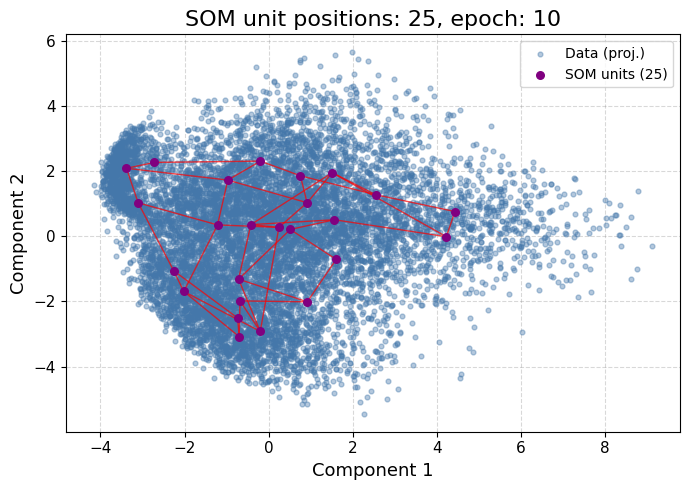

Training SOM: 100%|██████████| 100/100 [00:57<00:00,  1.74epoch/s]


Naive BMU-majority labeling accuracy (train subset): 72.66% (purely for visualization sanity check)


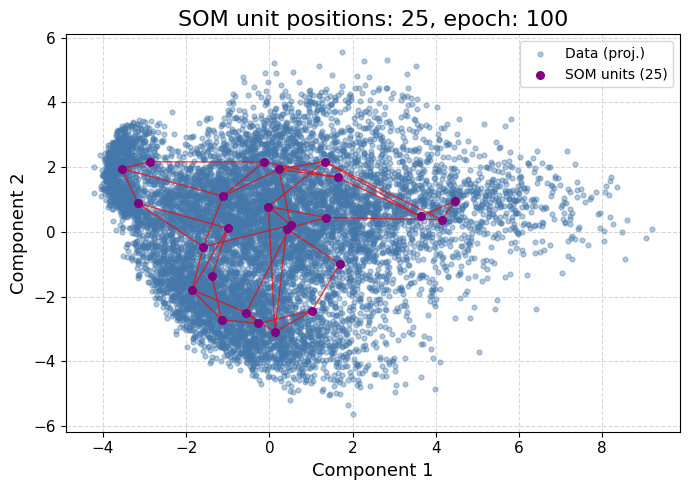

Training SOM: 100%|██████████| 250/250 [02:24<00:00,  1.73epoch/s]


Naive BMU-majority labeling accuracy (train subset): 71.73% (purely for visualization sanity check)


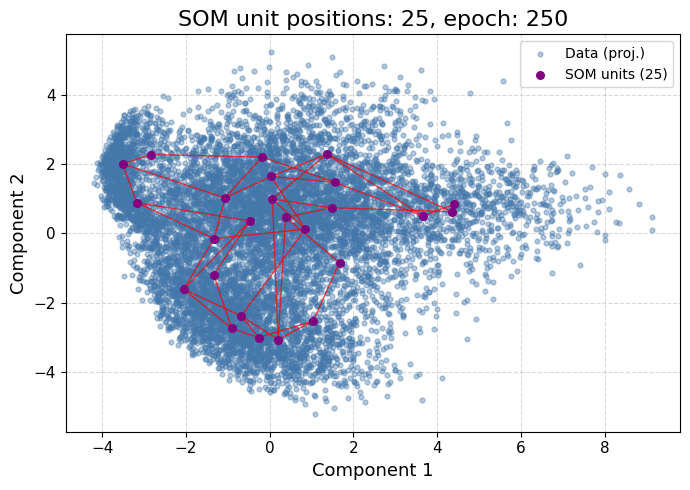

Training SOM: 100%|██████████| 10/10 [00:06<00:00,  1.64epoch/s]


Naive BMU-majority labeling accuracy (train subset): 82.40% (purely for visualization sanity check)


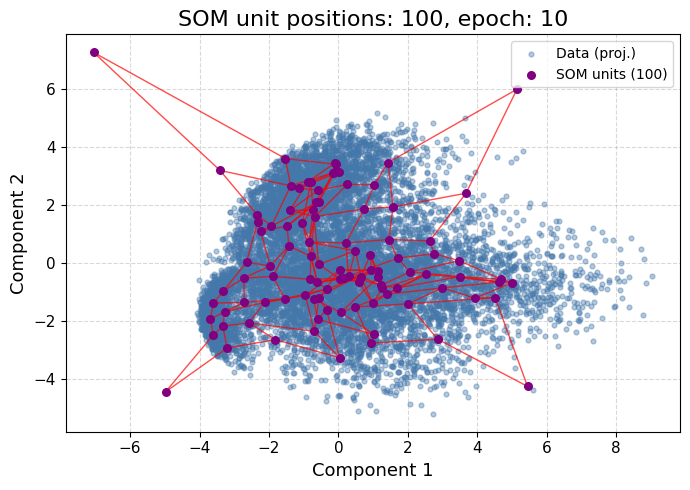

Training SOM: 100%|██████████| 100/100 [00:57<00:00,  1.73epoch/s]


Naive BMU-majority labeling accuracy (train subset): 86.63% (purely for visualization sanity check)


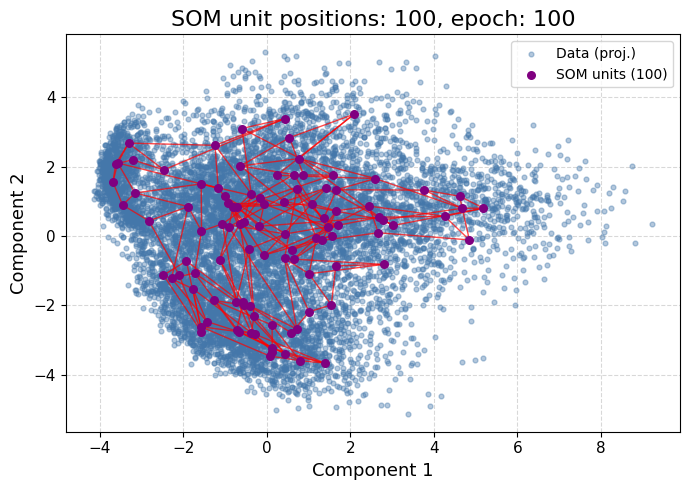

Training SOM: 100%|██████████| 250/250 [02:26<00:00,  1.70epoch/s]


Naive BMU-majority labeling accuracy (train subset): 86.98% (purely for visualization sanity check)


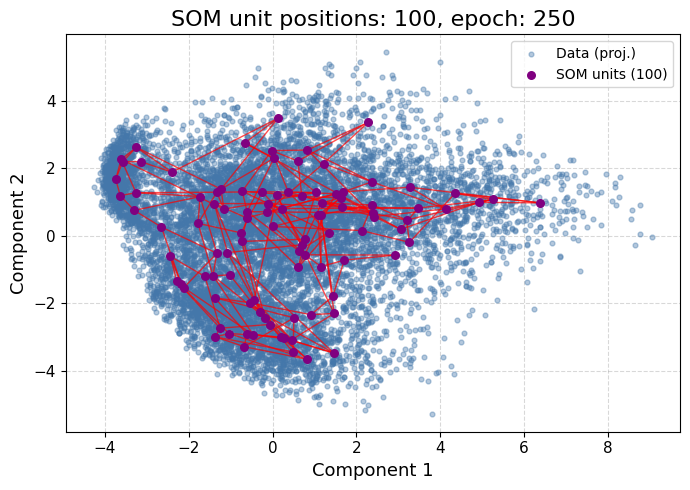

Training SOM: 100%|██████████| 10/10 [00:05<00:00,  1.83epoch/s]


Naive BMU-majority labeling accuracy (train subset): 83.31% (purely for visualization sanity check)


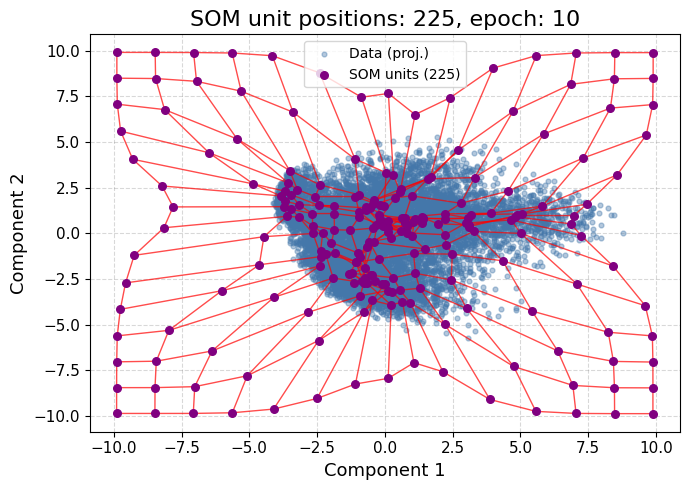

Training SOM: 100%|██████████| 100/100 [00:57<00:00,  1.73epoch/s]


Naive BMU-majority labeling accuracy (train subset): 89.31% (purely for visualization sanity check)


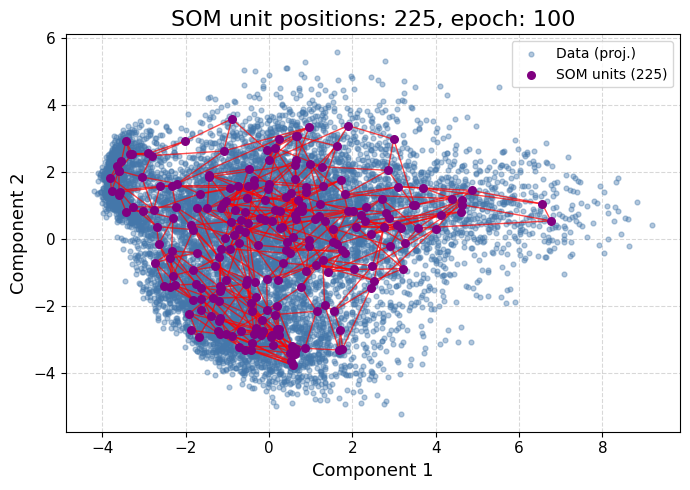

Training SOM: 100%|██████████| 250/250 [02:26<00:00,  1.70epoch/s]


Naive BMU-majority labeling accuracy (train subset): 90.35% (purely for visualization sanity check)


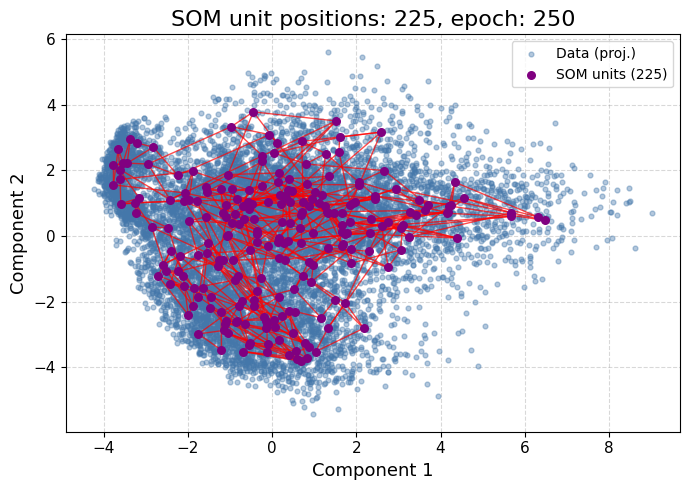

Training SOM: 100%|██████████| 10/10 [00:06<00:00,  1.62epoch/s]


Naive BMU-majority labeling accuracy (train subset): 83.46% (purely for visualization sanity check)


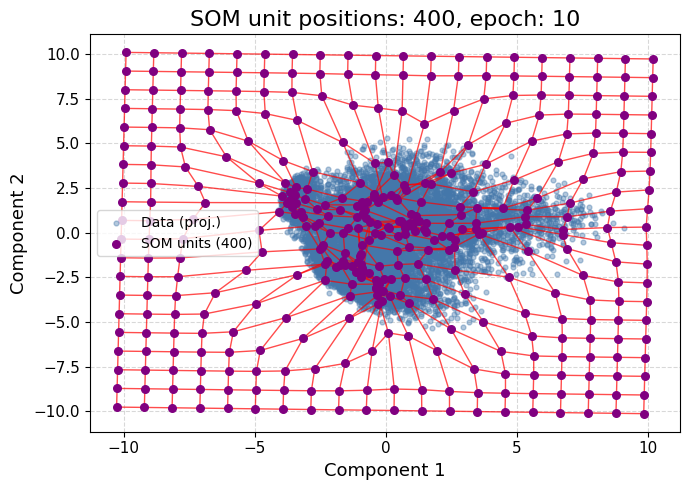

Training SOM: 100%|██████████| 100/100 [00:59<00:00,  1.69epoch/s]


Naive BMU-majority labeling accuracy (train subset): 90.52% (purely for visualization sanity check)


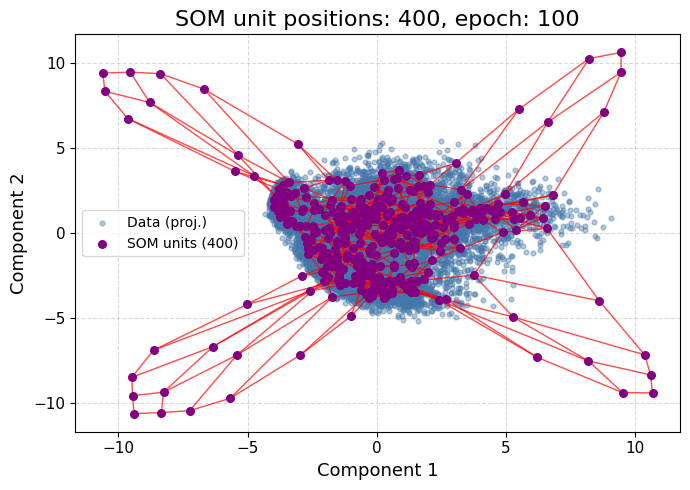

Training SOM: 100%|██████████| 250/250 [02:29<00:00,  1.67epoch/s]


Naive BMU-majority labeling accuracy (train subset): 91.87% (purely for visualization sanity check)


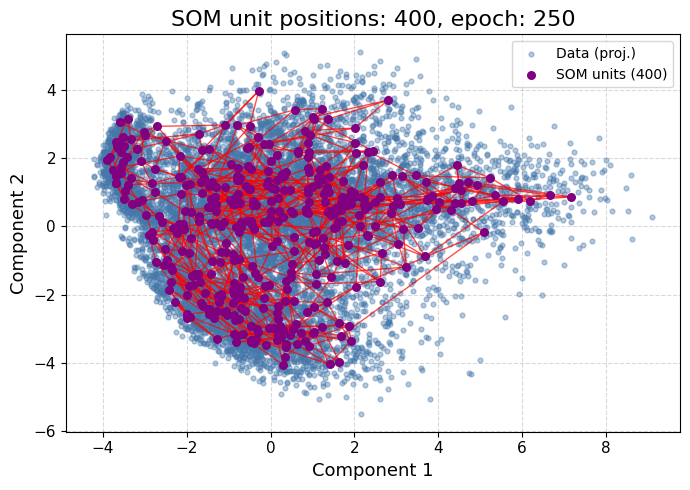

In [ ]:
# ablation study
SOM_LR = 0.5

resolutions = [5, 10, 15, 20]
epoch_list = [10, 100, 250]

for res in resolutions:
  for epoch in epoch_list:
    som_show_ablation(somx=res, somy=res, X_tensor=X_tensor, y_tensor=y_tensor, somepoch=epoch, somlr=SOM_LR)